# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.2)
sns.set_style('darkgrid')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SequentialFeatureSelector

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1.0 / (1 + np.exp(-X @ weights))
                      
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        loss1 = (np.log(1 + np.exp(-y.T * (x @ weights)))).mean()
        loss2 = np.linalg.norm(weights)**2 / (2 * self.C)
        loss = loss1 + loss2
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        self.loss_history = []
        
        for i in range(self.max_iter):
            delta = -np.mean( X_ext.T * y * (1 - (1 / (1 + np.exp(((-X_ext @ self.weights_).T * y).T)))), axis = 1 ).T + self.weights_ / self.C 
            
            self.loss_history.append(self.get_loss(X_ext, self.weights_, y))
            self.weights_ -= self.eta * delta       
            if np.linalg.norm(delta) < self.tol: 
                break
                    
        
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        
        return [1 if p >=0.5 else -1 for p in self.predict_proba(X)]

In [6]:
from sklearn import datasets
from sklearn import metrics

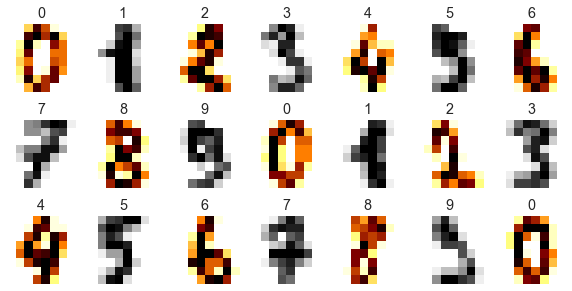

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true', ax=ax)
    disp.figure_.suptitle("Confusion Matrix")
    plt.grid(False)
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

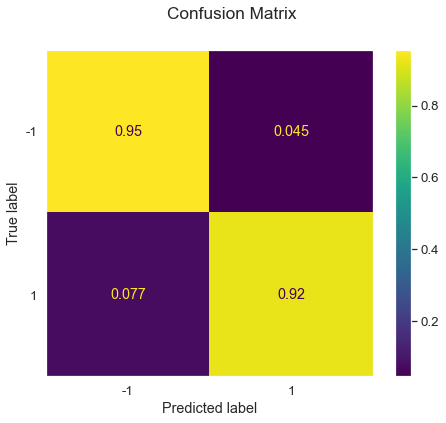

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

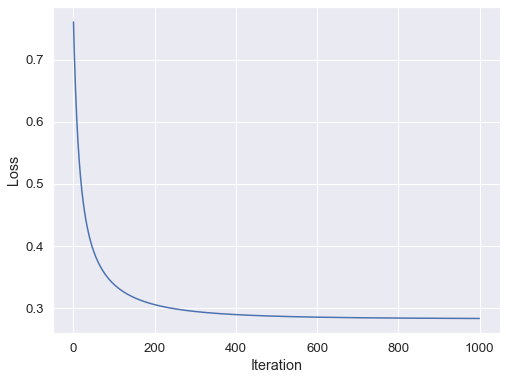

In [18]:
plt.figure(figsize=(8,6))
sns.lineplot(x=range(model.max_iter), y=model.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

As wee see our loss function has been minimized during using a gradient descent.

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

Let's decrease the learning rate and compare the results.

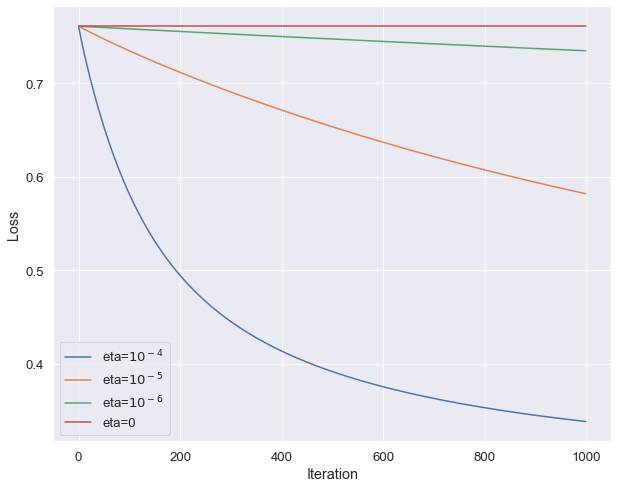

In [19]:
model1 = CustomLogisticRegression(eta=0.0001)
model2 = CustomLogisticRegression(eta=0.00001)
model3 = CustomLogisticRegression(eta=0.000001)
model4 = CustomLogisticRegression(eta=0)

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)

plt.figure(figsize = (10,8))
sns.lineplot(x=range(model1.max_iter), y=model1.loss_history)
sns.lineplot(x=range(model2.max_iter), y=model2.loss_history)
sns.lineplot(x=range(model3.max_iter), y=model3.loss_history)
sns.lineplot(x=range(model4.max_iter), y=model4.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(('eta=${10^-}^4}$', 'eta=${10^-}^5}$', 'eta=${10^-}^6}$', 'eta=0'));

With the learning rate's decreasing the convergence gets poorer. So we need too many iterations to converge to the best (optimal) values. Or even training may become permanently stuck with a high training error.

Now we'll increase the learning rate.

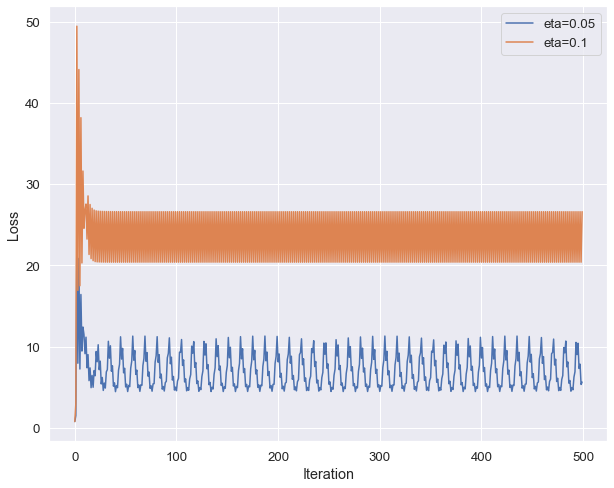

In [20]:
model5 = CustomLogisticRegression(eta=0.05, max_iter=500)
model6 = CustomLogisticRegression(eta=0.1, max_iter=500)

model5.fit(X_train, y_train)
model6.fit(X_train, y_train)

plt.figure(figsize = (10,8))
sns.lineplot(x=range(model5.max_iter), y=model5.loss_history)
sns.lineplot(x=range(model6.max_iter), y=model6.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(('eta=0.05', 'eta=0.1'));

We see a big wavering. Such performance is usually caused by weights that diverge  If the learning rate is very large we may skip the optimal solution.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

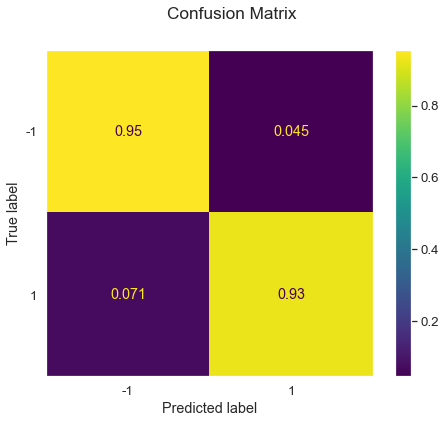

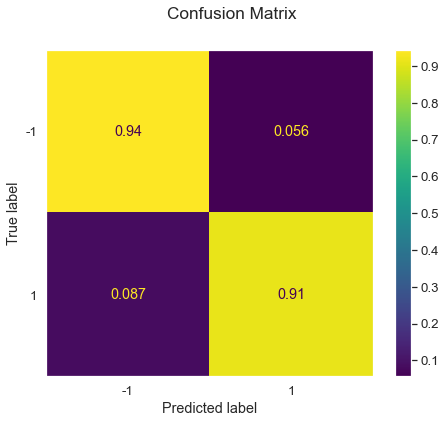

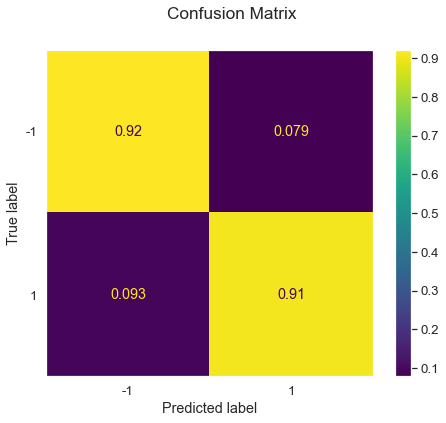

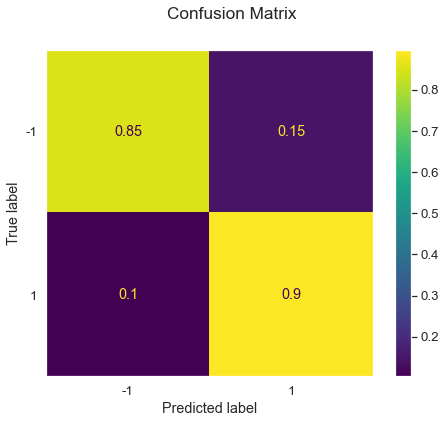

,C = 1.5,C = 0.5,C = 0.1,C = 0.01
train accuracy,0.913013,0.903967,0.887961,0.845511
test accuracy,0.941667,0.927778,0.913889,0.875000


In [21]:
model1 = CustomLogisticRegression(C=1.5)
model2 = CustomLogisticRegression(C=0.5)
model3 = CustomLogisticRegression(C=0.1)
model4 = CustomLogisticRegression(C=0.01)

train_acc1, test_acc1 = fit_evaluate(model1, X_train, y_train, X_test, y_test)
train_acc2, test_acc2 = fit_evaluate(model2, X_train, y_train, X_test, y_test)
train_acc3, test_acc3 = fit_evaluate(model3, X_train, y_train, X_test, y_test)
train_acc4, test_acc4 = fit_evaluate(model4, X_train, y_train, X_test, y_test)

df = pd.DataFrame(np.array([[train_acc1, train_acc2, train_acc3, train_acc4],
                   [test_acc1, test_acc2, test_acc3, test_acc4]
                  ]), 
                  index=['train accuracy', 'test accuracy'], 
                  columns=['C = 1.5', 'C = 0.5', 'C = 0.1', 'C = 0.01'])
display(df)

With decreaisng of regularization parameter C we see that model metrics don't get better. Bigger values specify stronger regularization as they decrease the weights.

**(0.5 points)** Compare zero initialization and random initialization. 

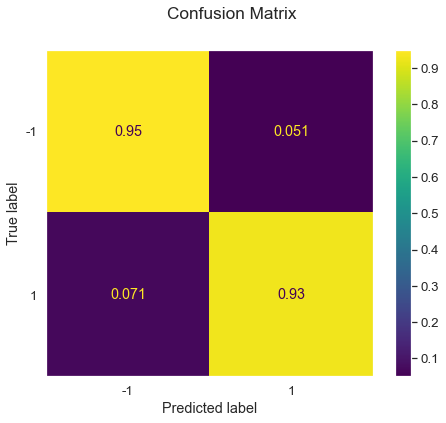

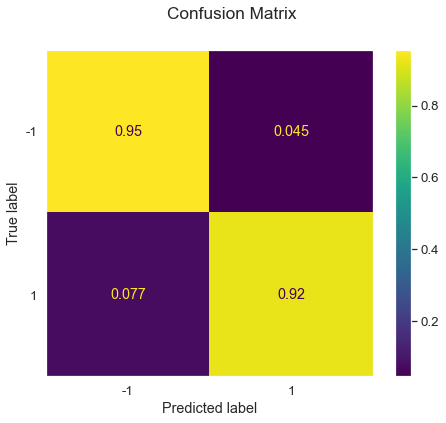

,zero initialization,random initialization
train accuracy,0.911621,0.910926
test accuracy,0.938889,0.938889


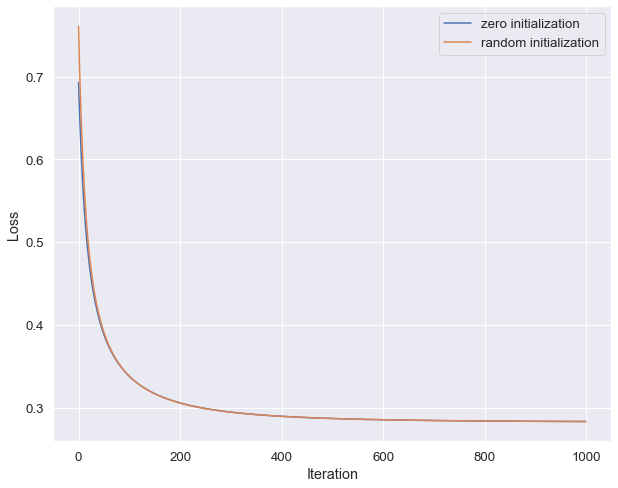

In [22]:
model_zero_init = CustomLogisticRegression(zero_init=True)
model_random_init = CustomLogisticRegression()

train_acc_zero, test_acc_zero = fit_evaluate(model_zero_init, X_train, y_train, X_test, y_test)
train_acc_random, test_acc_random = fit_evaluate(model_random_init, X_train, y_train, X_test, y_test)

df = pd.DataFrame(np.array([[train_acc_zero, train_acc_random],
                   [test_acc_zero, test_acc_random]
                  ]), 
                  index=['train accuracy', 'test accuracy'], 
                  columns=['zero initialization', 'random initialization'])
display(df)

plt.figure(figsize = (10,8))
sns.lineplot(x=range(model_zero_init.max_iter), y=model_zero_init.loss_history)
sns.lineplot(x=range(model_random_init.max_iter), y=model_random_init.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(('zero initialization', 'random initialization'));

Both zero and random initializations give a good result of our model performance. Nevertheless random initialization is usually used as it breaks symmetry and the performance of the model increases.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [23]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        
        n = X.shape[0]
        k = Y.shape[0]
        
        X_dots = (X ** 2).sum(axis=1).reshape((n,1)) * np.ones(shape=(1,k))
        Y_dots = (Y ** 2).sum(axis=1) * np.ones(shape=(n,1))
        dist =  X_dots + Y_dots - 2 * X @ Y.T       
        return np.sqrt(dist)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        p = []
        for i in self.classes_:
            idx = np.where(y == i)[0]
            p.append(weights[idx].sum())
        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            dist = np.sort(P, axis = 1)[:, :self.n_neighbors]
            y_dist = self.y[P.argsort(axis=1)[:, :self.n_neighbors]]
            weights_of_points = np.ones(dist.shape)
            
            if self.weights == 'distance':
                weights_of_points = 1 / (dist + self.eps)
                
            weights_i = np.array([self.get_class_weights(y_dist[i], weights_of_points[i]) for i in range(weights_of_points.shape[0])])
            Y_probability = weights_i / np.sum(weights_i, axis = 1)[:,None]
            
            return Y_probability
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
    
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return self.predict_proba(X).argmax(axis=1)

In [24]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [25]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [26]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

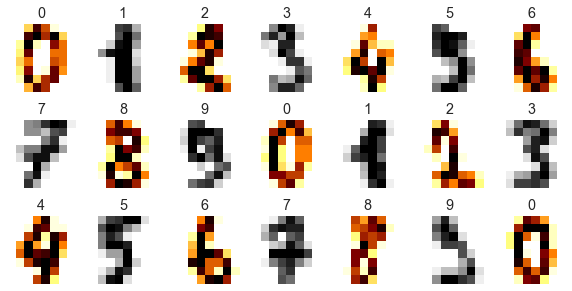

In [27]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [28]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [29]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

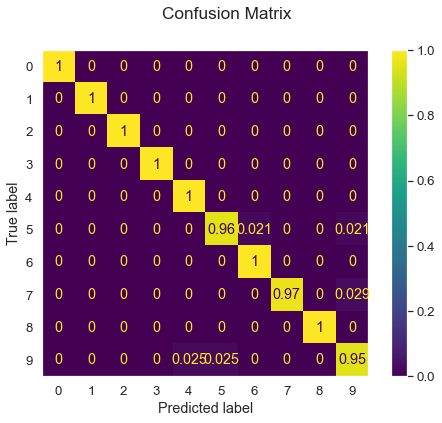

In [30]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [31]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Analyzing matrix we can make a conclusion that the model confuses **5 with 6 and 9**, **7 with 9**, **9 with 4 and 5**. This happens because the large number of pixels of these numbers have the same position relative to each other.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

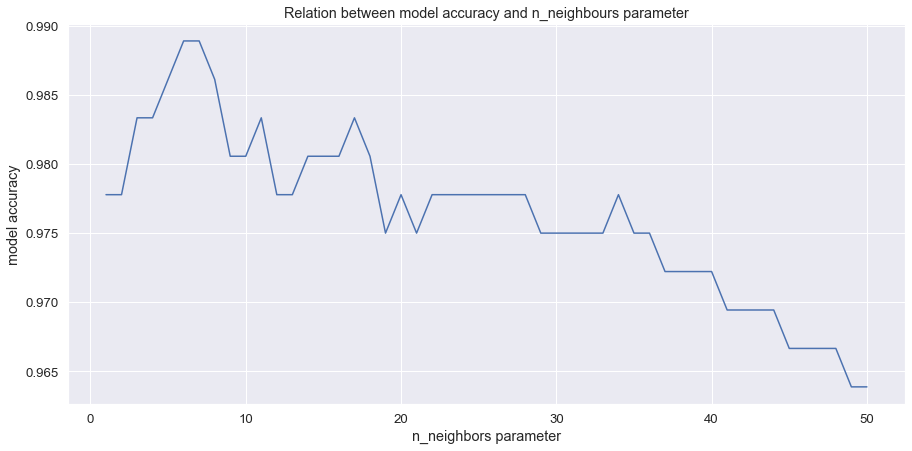

The maximum 0.989 of model accuracy is achieved at 6.0 neighbours


In [32]:
n_neighbors = np.linspace(1, 50, 1 + 49)
train_acc, test_acc  = [], []
for i in n_neighbors:
    model = CustomKNeighborsClassifier(n_neighbors = int(i), weights='distance')
    model.fit(X_train, y_train)
    test_acc.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))

plt.figure(figsize=(15, 7))
plt.plot(n_neighbors, test_acc)
plt.title('Relation between model accuracy and n_neighbours parameter')
plt.xlabel('n_neighbors parameter')
plt.ylabel('model accuracy')
plt.show()

print(f'The maximum {np.max(test_acc):.3f} of model accuracy is achieved at {n_neighbors[np.argmax(test_acc)]} neighbours')

So a small value of k means that noise will have a higher influence on the performance of our model, therefore the accuracy will be reduced; a large value makes it computationally expensive. 

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

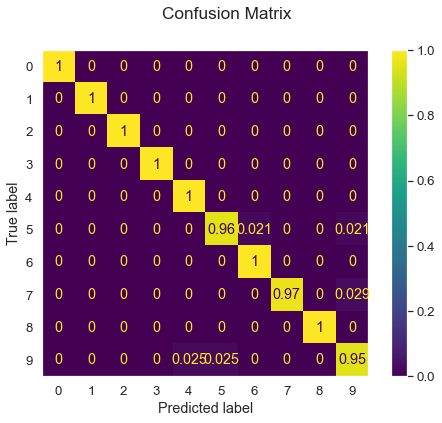

Train accuracy: 0.98956
Test accuracy: 0.98611


In [33]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='uniform')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

print(f'Train accuracy: {train_acc:.5f}\nTest accuracy: {test_acc:.5f}')

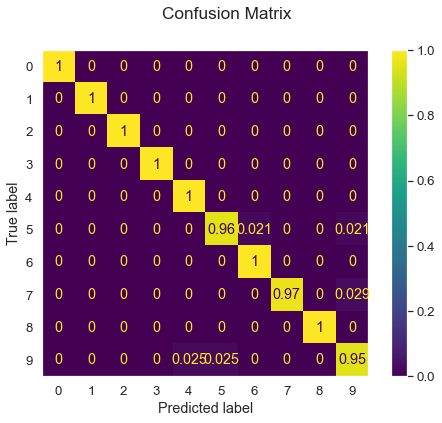

Train accuracy: 1.00000
Test accuracy: 0.98611


In [34]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

print(f'Train accuracy: {train_acc:.5f}\nTest accuracy: {test_acc:.5f}')

With **distance** weighting give better accuracy on train set. 
With **uniform** weighting the distance between the object and its k nearest neighbors isn't taken into account. They all have equal influence over the prediction. While with inverse distance weighting, we assign higher weights to the closer training examples.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

We could use **the standardized Euclidean distance** weights each variable with a separate variance. It's more efficient than just Euclidean distance as it standartalizes input variables that have different distributions.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

To detect some data corruption in transmission or storage we use **Hamming** distance. The Hamming distance between two equal-length strings of symbols counts the number of positions at which the corresponding symbols are different. So returning to our example, if one bit is flipped or two bits are flipped, the error can be detected.

**Hammimg** distance can not only detect errors but correct them as well.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [35]:
PATH = "data"

In [36]:
data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')

In [37]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [38]:
pd.crosstab(data['Sex'], data['Survived'], margins=True)

Survived,0,1,All
Sex,,,
female,12660,31226,43886
male,44566,11548,56114
All,57226,42774,100000


As we may see from the table above, there were **43886 females** and **56114 males** in the dataset. Among 100000 passengers **42774 has survived** and **57226 has not**.

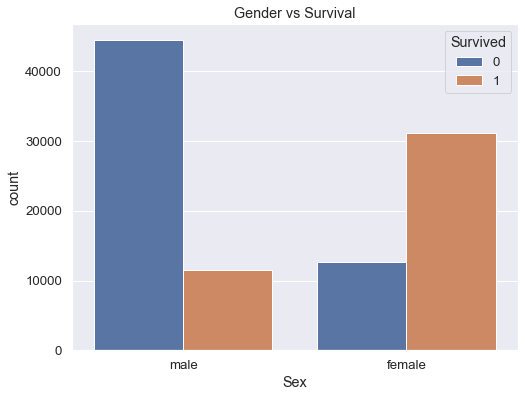

In [39]:
plt.figure(figsize=(8,6))
sns.countplot(x='Sex', data=data, hue='Survived')
plt.title('Gender vs Survival');

There's a strong relationship between the gender and the survival - women have much higher survival rates than men.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

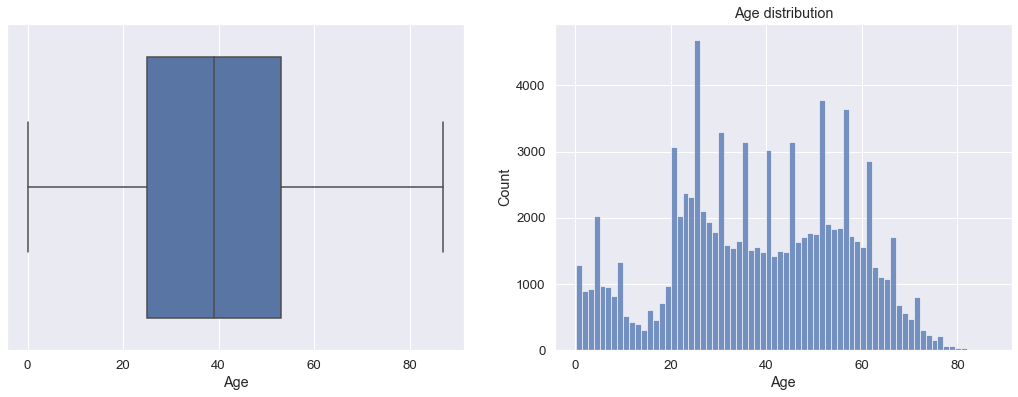

In [40]:
fig, ax = plt.subplots(1,2, figsize=(18,6))
sns.boxplot(data['Age'], ax=ax[0])
sns.histplot(data['Age'], bins=70, ax=ax[1])
plt.title('Age distribution');

Let's see what's the average and the median age of survived and deceassed passengers. 

In [41]:
data.groupby('Survived')['Age'].describe()[['mean', '50%']]

,mean,50%
Survived,,
0,36.708695,36.0
1,40.553799,43.0


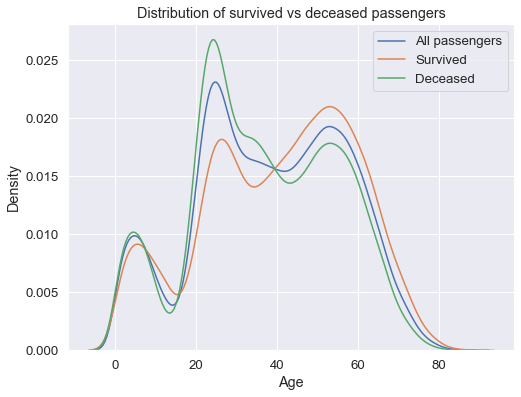

In [42]:
plt.figure(figsize=(8,6))
sns.kdeplot(data['Age'], label='All passengers')
sns.kdeplot(data[data['Survived'] == 1]['Age'], label='Survived')
sns.kdeplot(data[data['Survived'] == 0]['Age'], label='Deceased')
plt.title('Distribution of survived vs deceased passengers')
plt.legend();

Age distributions don't differ so much for survived and deceased passengers; we see that the average and the meadian age are almost the same.  I assume the distributions look the same because women and children were preferred to get on the boats.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

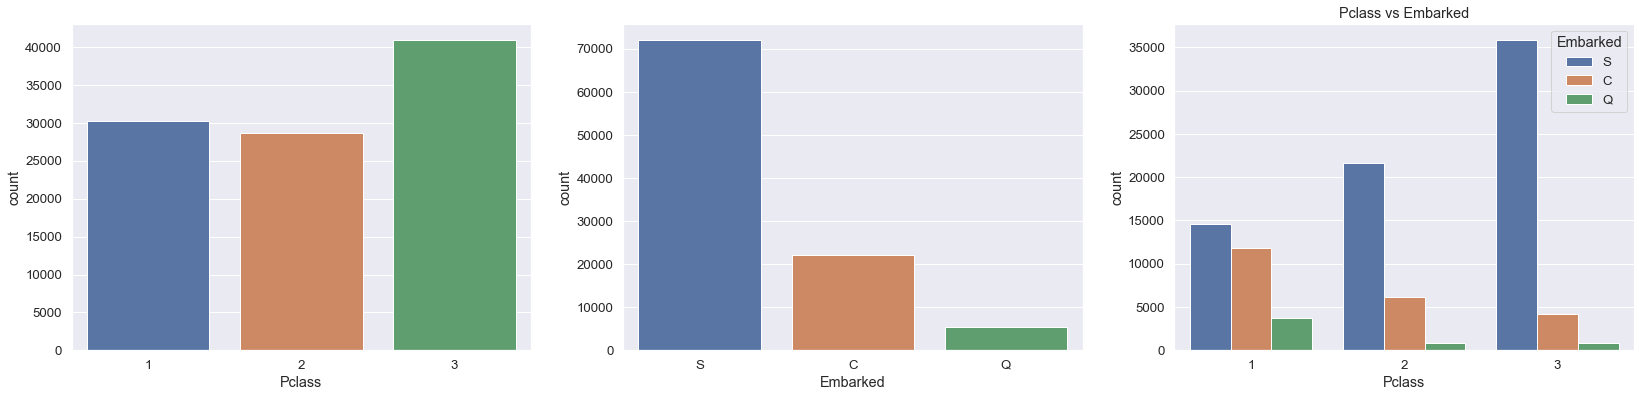

In [43]:
fig, ax = plt.subplots(1,3, figsize=(28,6))
sns.countplot(data['Pclass'], ax=ax[0]);
sns.countplot(data['Embarked'], ax=ax[1]);
sns.countplot(x='Pclass', hue='Embarked', data=data, ax=ax[2]);
ax[2].set_title('Pclass vs Embarked');

As we see the vast majority of passengers were from 3rd class and Southampton port.

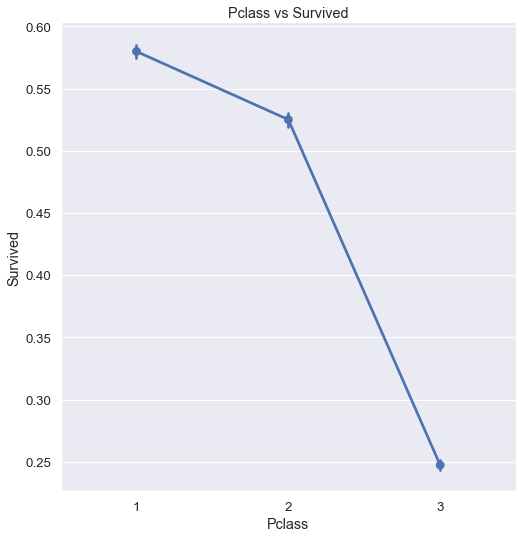

In [44]:
sns.catplot(x='Pclass', y='Survived', data=data, kind='point',height=7.5);
plt.title('Pclass vs Survived');

The 'safest' class is the 1st. With decreasing of class prestige survival rate is also deacresing. This is happening due to the fact that 1st class is the most expensive and the cabins of this class are located above the rest on the ship, so passengers more likely have time to get on the boats.

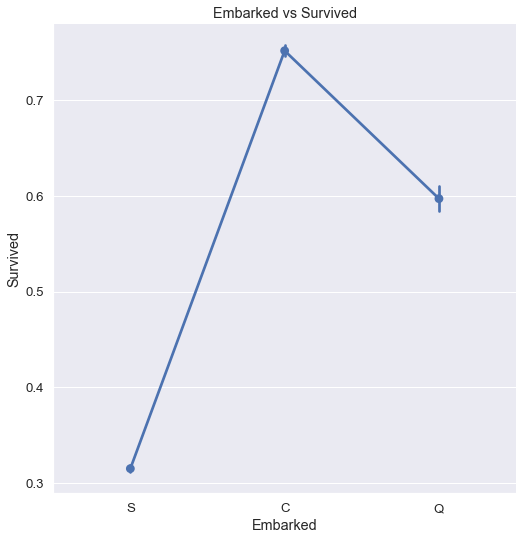

In [45]:
sns.catplot(x='Embarked', y='Survived', data=data, kind='point',height=7.5);
plt.title('Embarked vs Survived');

The passengers from Queenstown port have higher survival rate. As we explored above passengers from Southampton port were located at the cabins of the 3rd class, so their survival rate is very low.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [46]:
percent_of_null = data.isnull().sum() * 100 / data.shape[0]

percent_of_null \
    .to_frame() \
    .set_axis(['% of NaN'], axis=1) \
    .sort_values(by='% of NaN', ascending=False)

,% of NaN
Cabin,67.866
Ticket,4.623
Age,3.292
Embarked,0.250
Fare,0.134
Survived,0.000
Pclass,0.000
Name,0.000
Sex,0.000
SibSp,0.000


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

- Firstly let's deal with `Cabin`. 
It has around 68% of missing values. We'll replace them with **Unknown** and extract the first letter from all cabins.

In [47]:
data['Cabin'] = data['Cabin'].fillna('Unknown').apply(lambda x: x[0])

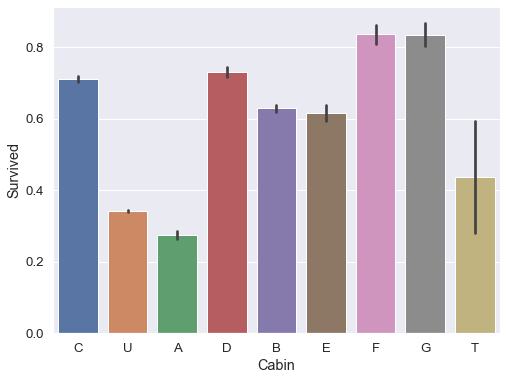

In [48]:
plt.figure(figsize=(8,6))
sns.barplot(x='Cabin', y='Survived', data=data);

The passengers in cabins `F`, `G`, `D`, `C` are higher rate of survival. Those passengers who don't have any cabin have less chances to survive.

- Let's deal with `Age`. 
At the graph below we may see that there's **a relationship between the age of the passengers and the cabin class number**. Indeed, the older the passenger, his well-being is higher, and, accordingly, the level of comfort that he can afford is higher. Thus, it's possible to replace the missing age values for the passenger with **the average age by cabin class number**. This will be more efficient than we would replace the missing values with the average age of all passengers.

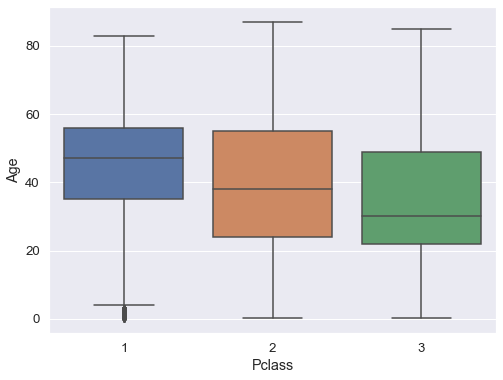

In [49]:
plt.figure(figsize=(8,6))
sns.boxplot(y='Age', x='Pclass', data=data);

In [50]:
data['Age'] = data.groupby('Pclass')['Age'].transform(lambda group: group.fillna(group.mean()))

- `Fare`.
A similar dependency is visible between the **Fare** and **Pclass** columns. The more prestigious the class and the more comfortable the conditions, the higher the average ticket price. Therefore, the missing values can be replaced by **the median by the class number**. We choose the median instead of the mean, because the meadian isn't affected by outliers.

Firstly, let's make sure that there're a lot of outliers in `Fare`.

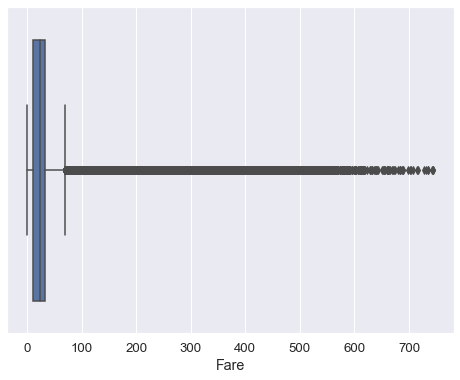

In [51]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Fare', data=data);

Let's remove some detected outliers

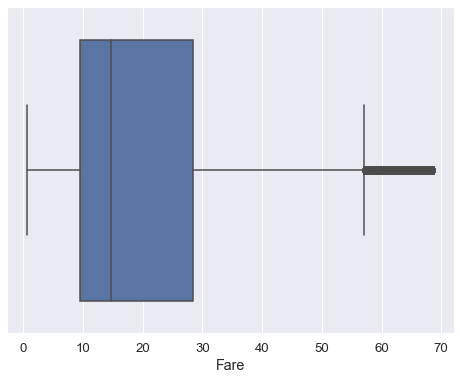

In [52]:
Q1 = data['Fare'].quantile(0.25)
Q3 = data['Fare'].quantile(0.75)
IQR = Q3 - Q1

data = data[(data['Fare'] < (Q3 + 1.5 * IQR)) & (data['Fare'] > Q1 - 1.5 * IQR)]

plt.figure(figsize=(8,6))
sns.boxplot(x='Fare', data=data);

In [53]:
data['Fare'] = data.groupby('Pclass')['Fare'].transform(lambda group: group.fillna(group.median()))

As the `Fare` has left skewed distribution it's efficient to use log normalization method.

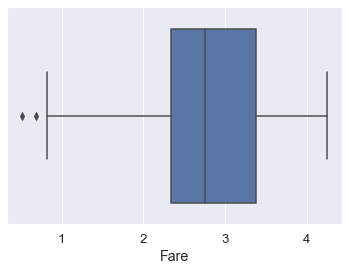

In [54]:
data['Fare'] = data['Fare'].apply(lambda x: np.log(x + 1)).astype(np.float64)
sns.boxplot(x='Fare', data=data);

- `Embarked`.
It's a categorical variable, that's why we'll replace the missing values by **the mode**.

In [55]:
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

- `Ticket`. It's also a categorical variable and  we'll replace the missing values by **the mode**.

In [56]:
data['Ticket'] = data['Ticket'].fillna(data['Ticket'].mode()[0])

Let's check that we replaced all the missing values in our dataset.

In [57]:
data.isnull().sum().sum()

0

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

- `SibSp` and `Parch`; `Cabin` could be useful united as categorical variable

In [58]:
data['Not_alone'] = [0 if a == 0 else 1 for a in data['SibSp'] + data['Parch']]
data['Have_cabin'] = [0 if a == 'U' else 1 for a in data['Cabin']]

- Let's convert `Sex` and  `Embarked` to int

In [59]:
data['Sex'].replace(('male','female'), (0,1), inplace = True)
data['Embarked'].replace(('C','Q','S'), (0,1,2), inplace = True)

- Let's discretize `Fare` and `Age` into 5 equal bins and encode them. 

In [60]:
label = LabelEncoder()

In [61]:
fare_bins = pd.qcut(data['Fare'], 3)
data['Fare_bins_code'] = label.fit_transform(fare_bins)

age_bins = pd.qcut(data['Age'], 5)
data['Age_bins_code'] = label.fit_transform(age_bins)

- Now we'll get rid of unuseful columns

In [62]:
data[:3]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Not_alone,Have_cabin,Fare_bins_code,Age_bins_code
PassengerId,,,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",0,44.774464,2,0,209245,3.337192,C,2,1,1,2,3
1,0,3,"Bryan, Drew",0,33.407362,0,0,27323,2.663750,U,2,0,0,1,2
3,0,3,"Kramer, James",0,19.000000,0,0,A. 10866,2.641910,U,2,0,0,1,0


In [63]:
columns_to_delete = ['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin']
data.drop(columns_to_delete, axis=1, inplace=True)
data[:3]

,Survived,Pclass,Sex,Embarked,Not_alone,Have_cabin,Fare_bins_code,Age_bins_code
PassengerId,,,,,,,,
0,1,1,0,2,1,1,2,3
1,0,3,0,2,0,0,1,2
3,0,3,0,2,0,0,1,0


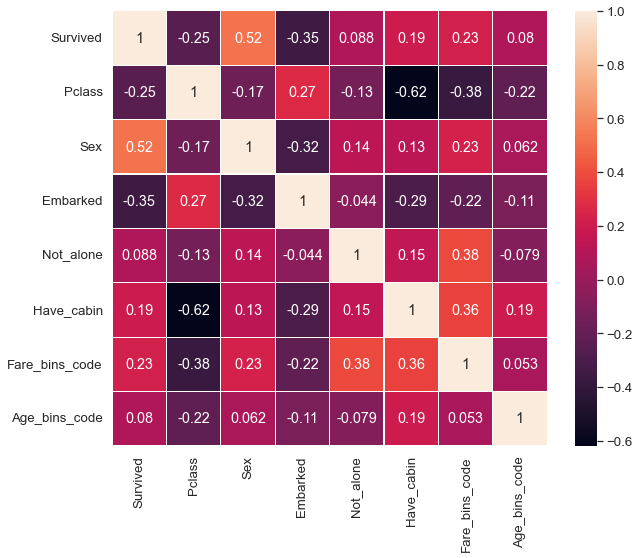

In [64]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(),linewidths=0.1, square=True,  linecolor='white', annot=True)
plt.show()

- We'll define **y_train** as our target `Survived` and **X_train** as other variables

In [65]:
y = data['Survived']
X_train = data.iloc[:,1:]

- We'll scale input data

In [66]:
X_scaled = StandardScaler().fit_transform(X_train)

In [67]:
SEED = 40

In [68]:
knn = KNeighborsClassifier()
logr = LogisticRegression(random_state=SEED)

- Let's evaluate accuracy both for KNN and Logistic Regression by cross-validation

In [69]:
cross_val_score(knn, X_scaled, y, scoring='accuracy').mean()

0.7414666586058885

In [70]:
cross_val_score(logr, X_scaled, y, scoring='accuracy').mean()

0.7737017109001874

Logistic Regression has better performance. We'll use it to the end.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

- We'll do hyperparameters tuning using **GridSearchCV**

In [71]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg=LogisticRegression(random_state=SEED)
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_scaled,y)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=40),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [72]:
print("Tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("Best accuracy :",logreg_cv.best_score_)

Tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
Best accuracy : 0.7740039900852428


- **Final predictions**

In [73]:
test_data = pd.read_csv(os.path.join(PATH, 'test.csv')).set_index('PassengerId')

In [74]:
def feature_preparation(data):
    data['Cabin'] = data['Cabin'].fillna('Unknown').apply(lambda x: x[0])
    data['Age'] = data.groupby('Pclass')['Age'].transform(lambda group: group.fillna(group.mean()))
    data['Fare'] = data.groupby('Pclass')['Fare'].transform(lambda group: group.fillna(group.median()))
    data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
    data['Ticket'] = data['Ticket'].fillna(data['Ticket'].mode()[0])
    
    data['Not_alone'] = [0 if a == 0 else 1 for a in data['SibSp'] + data['Parch']]
    data['Have_cabin'] = [0 if a == 'U' else 1 for a in data['Cabin']]
    
    data['Sex'].replace(('male','female'), (0,1), inplace = True)
    data['Embarked'].replace(('C','Q','S'), (0,1,2), inplace = True)
    
    data['Fare'] = data['Fare'].apply(lambda x: np.log(x + 1).astype(np.float64))
    fare_bins = pd.qcut(data['Fare'], 3)
    data['Fare_bins_code'] = label.fit_transform(fare_bins)

    age_bins = pd.qcut(data['Age'], 5)
    data['Age_bins_code'] = label.fit_transform(age_bins)
    
    columns_to_delete = ['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Age', 'Fare']
    data.drop(columns_to_delete, axis=1, inplace=True)
    
    return data

In [75]:
test_data = feature_preparation(test_data)

In [76]:
X_test = test_data

In [77]:
X_test_scaled = StandardScaler().fit_transform(X_test)

In [78]:
logr = LogisticRegression(penalty='l2', C=0.001, random_state=SEED)
logr.fit(X_scaled, y)

y_pred = logr.predict(X_test_scaled)

In [79]:
submission = pd.DataFrame({
        'PassengerId': test_data.index,
        'Survived': y_pred
    })
submission.to_csv(os.path.join(PATH, 'submission.csv'), index=False)

In [80]:
out = pd.read_csv(os.path.join(PATH, 'submission.csv'))
out

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1
...,...,...
99995,199995,1
99996,199996,0
99997,199997,0
99998,199998,1


**My results:**

<img src="result.png">

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.